# [B] Optimizing Qwen-Image (Text-to-Image) Inference Hands-on with Intel® Gaudi®

## What you will do
- **Stage 0 (Fail on purpose)**: Eager mode(PT_HPU_LAZY_MODE=0) (no patch) → observe RoPE complex dtype error on Gaudi
- **Stage 1 (Fix correctness)**: Eager mode(PT_HPU_LAZY_MODE=0) + Fix RoPE layer
- **Stage 2 (Kernel Optimization)**: Eager mode(PT_HPU_LAZY_MODE=0) + Fix RoPE layer + Apply FusedSDPA(for Gaudi) kernel
- **Stage 3 (Hpu graphs mode)**: HPU graph mode(PT_HPU_LAZY_MODE=1) + Fix RoPE layer + Apply FusedSDPA(for Gaudi) kernel


## Stage runner
We use `run_qwen_latency.py` as the single runner and toggle behavior using flags:
- `--patch-rope`: apply Gaudi-optimized RoPE functions from `gaudi_transformer_qwenimage.py`
- `--patch-fused-attn`: switch attention compute to the Habana fused kernel path

In [1]:
!pip install diffusers==0.35.1
!pip install transformers==4.55.4
!pip install matplotlib
!pip install accelerate




# Stage 0 — Unpatched run (expected to fail on Gaudi)
We intentionally run **without** `--patch-rope` to show the RoPE failure on Gaudi:
- Expected error: `RuntimeError: Complex datatype is not supported on Gaudi device.`

This cell is written to **not stop the notebook** (it will catch the non-zero exit).


In [2]:
%%bash
# Strict mode: -u (error on undefined vars), -o pipefail (fail if any pipe fails)
set -uo pipefail

export HF_HUB_CACHE="/workspace/models/hub"
export PT_HPU_LAZY_MODE=0

# Allow this command to fail without stopping the notebook
# Stage 0 is expected to fail (RoPE complex dtype error)
set +e
python run_qwen_latency.py \
  --prompt "A cute cat holding a sign that says hello world" \
  --negative-prompt " " \
  --width 1024 --height 1024 \
  --steps 28 \
  --seed 42 \
  --num-runs 2 --skip 0 \
  --output stage0_unpatched.png
rc=$?
set -e

# Force successful exit so subsequent cells can run
exit 0


Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Multiple distributions found for package optimum. Picked distribution: optimum-habana


[INFO] Enabled _set_math_sdp_allow_fp16_bf16_reduction(True)
[run_qwen_latency] {'model_id': 'Qwen/Qwen-Image', 'device': 'hpu', 'dtype': 'bf16', 'mode': 'eager', 'lazy_mode': '0', 'patch_rope': False, 'patch_fused_attn': False, 'steps': 28, 'size': '1024x1024', 'num_runs': 2, 'skip': 0, 'true_cfg_scale': 4.0}
[INFO] PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807


Loading pipeline components...:  40%|████      | 2/5 [00:00<00:00,  6.64it/s]The config attributes {'pooled_projection_dim': 768} were passed to QwenImageTransformer2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.66it/s]
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 ============= 
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 0
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 2015 GB
------------------------------------------------------------------------------
  0%|          | 0/28 [00:00<?, ?it/s]
Traceback (most recen

# Stage 1 — Apply RoPE patch (make it work on Gaudi)
Now we enable `--patch-rope` so the pipeline runs successfully on Gaudi.

This stage keeps `PT_HPU_LAZY_MODE=0` so we isolate the **correctness fix** first.


### Problem: Complex Data Types Not Supported on Gaudi

The RoPE implementation in the Qwen-Image model uses **complex number operations**:

```python
# Original diffusers code (transformer_qwenimage.py)
self.pos_freqs = torch.polar(torch.ones_like(freqs), freqs)  # complex64

```

Attempting to move this complex tensor to an Gaudi device results in an error:

```
RuntimeError: Complex datatype is not supported on HPU device.

```

### Solution: Real Number-Based RoPE Implementation

The `--patch-rope` flag replaces the original code with an optimized implementation in `gaudi_transformer_qwenimage.py`:

| Aspect | Original (diffusers) | After Patch (Gaudi) |
| --- | --- | --- |
| Data Type | `complex64` | `bfloat16` (separate cos, sin) |
| Operation Method | Uses `torch.polar()` | Calculates cos/sin separately |
| Gaudi Compatibility | ❌ Not Supported | ✅ Fully Supported |

### Code Comparison**Original (Using Complex Numbers):**

```python
# Uses complex polar form
freqs = torch.polar(torch.ones_like(freqs), freqs)  # e^(i*theta)
x_out = x * freqs  # Complex multiplication

```

**After Patch (Separated Real Numbers):**

```python
# Calculates cos and sin separately
cos_freqs = torch.cos(freqs)
sin_freqs = torch.sin(freqs)

# Applies rotation using real number arithmetic
out_real = x_real * cos - x_imag * sin
out_imag = x_real * sin + x_imag * cos

```

### Mathematical EquivalenceComplex 

Rotation: $z \cdot e^{i\theta} = (a + bi)(cos\theta + i \cdot sin\theta)$

Separated Real Implementation:

- $real = a \cdot cos\theta - b \cdot sin\theta$
- $imag = a \cdot sin\theta + b \cdot cos\theta$

Both methods produce **mathematically identical results**, but the separated real number method is executable on the HPU.

In [3]:
%%bash
set -euo pipefail

export HF_HUB_CACHE="/workspace/models/hub"
export PT_Gaudi_LAZY_MODE=0

python run_qwen_latency.py \
  --prompt "A cute cat holding a sign that says hello world" \
  --negative-prompt " " \
  --width 1024 --height 1024 \
  --steps 28 \
  --seed 42 \
  --num-runs 4 --skip 0 \
  --patch-rope \
  --output stage1_rope_eager.png


Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Multiple distributions found for package optimum. Picked distribution: optimum-habana


[INFO] Enabled _set_math_sdp_allow_fp16_bf16_reduction(True)
[run_qwen_latency] {'model_id': 'Qwen/Qwen-Image', 'device': 'hpu', 'dtype': 'bf16', 'mode': 'eager', 'lazy_mode': '', 'patch_rope': True, 'patch_fused_attn': False, 'steps': 28, 'size': '1024x1024', 'num_runs': 4, 'skip': 0, 'true_cfg_scale': 4.0}
[INFO] PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]The config attributes {'pooled_projection_dim': 768} were passed to QwenImageTransformer2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.25it/s]
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 ============= 
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 0
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 2015 GB
------------------------------------------------------------------------------
100%|██████████| 28/28 [00:41<00:00,  1.49s/it]


[iter] 1/4 latency_sec=44.4440


100%|██████████| 28/28 [00:40<00:00,  1.46s/it]


[iter] 2/4 latency_sec=43.9404


100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


[iter] 3/4 latency_sec=44.6457


100%|██████████| 28/28 [00:42<00:00,  1.53s/it]


[iter] 4/4 latency_sec=44.7115
[summary] mean_sec=44.4354 p50_sec=44.5448 p90_sec=44.6917 runs=4
[output] saved_image=outputs/stage1_rope_eager.png
[output] saved_latency_json=outputs/stage1_rope_eager.json


# Stage 2 — RoPE + fused attention
If your environment supports Habana fused kernels, this can further improve attention performance.


### Background: Memory Bottleneck in Attention OperationsSelf-Attention in Transformers consists of the following steps:

1. **QKV Projection**: Linear operation
2. **Attention Score Calculation**: $QK^T / \sqrt{d}$
3. **Softmax**: Probability distribution for each position
4. **Value Weighted Sum**: $\text{softmax}(QK^T)V$

In standard PyTorch implementations, **intermediate results are stored in memory** at each step.
In particular, the Attention Score matrix consumes memory proportional to the square of the sequence length.

### Solution: Habana FusedSDPA

The `--patch-fused-attn` flag utilizes Habana's **FusedSDPA (Fused Scaled Dot-Product Attention)** kernel:

```python
from habana_frameworks.torch.hpex.kernels import FusedSDPA

# Original: PyTorch SDPA (Stores intermediate results in memory)
output = F.scaled_dot_product_attention(query, key, value)

# After Patch: Habana FusedSDPA (Fused processing within the kernel)
# Note: Ensure arguments match the official API signature (q, k, v, mask, dropout, causal, scale)
output = FusedSDPA.apply(query, key, value, None, 0.0, False, None, "fast", None)

```

### Performance Improvement Principles

| Item | Standard SDPA | Habana FusedSDPA |
| --- | --- | --- |
| **Memory Access** | Read/Write at each step | Utilizes internal kernel registers |
| **Intermediate Tensor Storage** | ✅ Stores Attention Scores | ❌ Does not store |
| **Operation Fusion** | Individual kernel calls | Single fused kernel |
| **Memory Bandwidth** | High usage | Optimized usage |

### Qwen-Image Special Structure: Double-Stream Attention

Qwen-Image uses a specialized structure that processes **text streams** and **image streams** together:

```python
# Combine QKV for text and image (Joint Attention)
joint_query = torch.cat([txt_query, img_query], dim=1)
joint_key = torch.cat([txt_key, img_key], dim=1)
joint_value = torch.cat([txt_value, img_value], dim=1)

# Integrated processing with FusedSDPA
joint_hidden_states = FusedSDPA.apply(
    joint_query.transpose(1, 2),
    joint_key.transpose(1, 2),
    joint_value.transpose(1, 2),
    None, 0.0, False, None, "fast", None
)

# Separate results
txt_output = joint_hidden_states[:, :seq_txt, :]
img_output = joint_hidden_states[:, seq_txt:, :]

```

### Expected Benefits
* **Reduced Latency**: Approx. 1.5x speedup
* **Memory Efficiency**: Saves memory by not storing intermediate Attention Score tensors
* **Increased Throughput**: Enables processing of larger batches or higher resolutions within the same memory footprint

In [4]:
%%bash
set -euo pipefail

export HF_HUB_CACHE="/workspace/models/hub"
export PT_HPU_LAZY_MODE=0
# Prevent OOM by setting large compound op size (diffusers sets this to 1 by default)
export PT_HPU_MAX_COMPOUND_OP_SIZE=9223372036854775807

# Stage 2: RoPE + fused attention
python run_qwen_latency.py \
  --prompt "A cute cat holding a sign that says hello world" \
  --negative-prompt " " \
  --width 1024 --height 1024 \
  --steps 28 \
  --seed 42 \
  --num-runs 4 --skip 0 \
  --patch-rope \
  --patch-fused-attn \
  --output stage2_rope_sdpa_eager.png


Calling add_step_closure function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Calling iter_mark_step function does not have any effect. It's lazy mode only functionality. (warning logged once)
Multiple distributions found for package optimum. Picked distribution: optimum-habana


[INFO] Enabled _set_math_sdp_allow_fp16_bf16_reduction(True)
[run_qwen_latency] {'model_id': 'Qwen/Qwen-Image', 'device': 'hpu', 'dtype': 'bf16', 'mode': 'eager', 'lazy_mode': '0', 'patch_rope': True, 'patch_fused_attn': True, 'steps': 28, 'size': '1024x1024', 'num_runs': 4, 'skip': 0, 'true_cfg_scale': 4.0}
[INFO] PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807


Loading pipeline components...:  20%|██        | 1/5 [00:00<00:00,  7.60it/s]The config attributes {'pooled_projection_dim': 768} were passed to QwenImageTransformer2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.

Loading pipeline components...: 100%|██████████| 5/5 [00:00<00:00,  6.42it/s]
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 ============= 
 PT_HPU_LAZY_MODE = 0
 PT_HPU_RECIPE_CACHE_CONFIG = ,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 0
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 2015 GB
------------------------------------------------------------------------------
100%|██████████| 28/28 [00:27<00:00,  1.00it/s]


[iter] 1/4 latency_sec=29.2010


100%|██████████| 28/28 [00:28<00:00,  1.03s/it]


[iter] 2/4 latency_sec=30.0103


100%|██████████| 28/28 [00:26<00:00,  1.04it/s]


[iter] 3/4 latency_sec=29.4674


100%|██████████| 28/28 [00:29<00:00,  1.05s/it]


[iter] 4/4 latency_sec=30.4193
[summary] mean_sec=29.7745 p50_sec=29.7388 p90_sec=30.2966 runs=4
[output] saved_image=outputs/stage2_rope_sdpa_eager.png
[output] saved_latency_json=outputs/stage2_rope_sdpa_eager.json


# Stage 3 — Using HPU graph mode (after RoPE+FusedSDPA patch)
Now that correctness is fixed, we switch to `PT_HPU_LAZY_MODE=1` + `wrap_in_hpu_graph` and measure latency again.

### How `wrap_in_hpu_graph` is Applied

When you run with `--mode hpu_graphs`, the runner script (`run_qwen_latency.py`) does the following:

1. **Sets pipeline stages**: `pipe.stages = ["transformer"]`
2. **Defines repeated blocks**: `pipe._repeated_blocks = ["QwenImageTransformerBlock"]`
3. **Wraps individual blocks**: Instead of wrapping the entire transformer at once, `wrap_in_hpu_graph()` is applied to each `QwenImageTransformerBlock` separately

```python
# From run_qwen_latency.py: _compile_pipeline_modules()
for name, module in transformer.named_modules():
    if module.__class__.__name__ == "QwenImageTransformerBlock":
        # Wrap each block individually
        setattr(parent, child_name, wrap_in_hpu_graph(module))
```

**Why wrap blocks individually?**
- **Shape flexibility**: Each block can have its own graph cache, avoiding locking to warmup shapes
- **Memory efficiency**: Smaller graphs consume less memory during compilation
- **Better performance**: Block-level graphs can be reused more efficiently across different sequence lengths

**Required environment**:
- `PT_HPU_LAZY_MODE=1`: Enables lazy execution (required for HPU graphs)
- `PT_HPU_RECIPE_CACHE_CONFIG`: Specifies where to cache compiled graphs


In [5]:
%%bash
set -euo pipefail

export HF_HUB_CACHE="/workspace/models/hub"
# Cache path to save compiled graphs recipe.
export PT_HPU_RECIPE_CACHE_CONFIG=/tmp/gaudi_graphs,false,1024,false
export PT_HPU_LAZY_MODE=1
# Prevent OOM by setting large compound op size (diffusers sets this to 1 by default)
export PT_HPU_MAX_COMPOUND_OP_SIZE=9223372036854775807

python run_qwen_latency.py \
  --prompt "A cute cat holding a sign that says hello world" \
  --negative-prompt " " \
  --width 1024 --height 1024 \
  --steps 28 \
  --seed 42 \
  --num-runs 6 --skip 2 \
  --patch-rope \
  --patch-fused-attn \
  --mode hpu_graphs \
  --output stage3_rope_sdpa_graph.png


Multiple distributions found for package optimum. Picked distribution: optimum-habana


[INFO] Enabled _set_math_sdp_allow_fp16_bf16_reduction(True)
[run_qwen_latency] {'model_id': 'Qwen/Qwen-Image', 'device': 'hpu', 'dtype': 'bf16', 'mode': 'hpu_graphs', 'lazy_mode': '1', 'patch_rope': True, 'patch_fused_attn': True, 'steps': 28, 'size': '1024x1024', 'num_runs': 6, 'skip': 2, 'true_cfg_scale': 4.0}
[INFO] PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807


Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]The config attributes {'pooled_projection_dim': 768} were passed to QwenImageTransformer2DModel, but are not expected and will be ignored. Please verify your config.json configuration file.

Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  4.93it/s]
============================= HPU PT BRIDGE CONFIGURATION ON RANK = 0 ============= 
 PT_HPU_LAZY_MODE = 1
 PT_HPU_RECIPE_CACHE_CONFIG = /tmp/gaudi_graphs,false,1024,false
 PT_HPU_MAX_COMPOUND_OP_SIZE = 9223372036854775807
 PT_HPU_LAZY_ACC_PAR_MODE = 1
 PT_HPU_ENABLE_REFINE_DYNAMIC_SHAPES = 0
 PT_HPU_EAGER_PIPELINE_ENABLE = 1
 PT_HPU_EAGER_COLLECTIVE_PIPELINE_ENABLE = 1
 PT_HPU_ENABLE_LAZY_COLLECTIVES = 0
---------------------------: System Configuration :---------------------------
Num CPU Cores : 160
CPU RAM       : 2015 GB
------------------------------------------------------------------------------
100%|██████████| 28/28 [00:17<00:00,  1.59it/s]


[iter] 1/6 latency_sec=75.1658


100%|██████████| 28/28 [00:16<00:00,  1.68it/s]


[iter] 2/6 latency_sec=18.3930


100%|██████████| 28/28 [00:16<00:00,  1.69it/s]


[iter] 3/6 latency_sec=18.3057


100%|██████████| 28/28 [00:16<00:00,  1.69it/s]


[iter] 4/6 latency_sec=18.3042


100%|██████████| 28/28 [00:16<00:00,  1.69it/s]


[iter] 5/6 latency_sec=18.3034


100%|██████████| 28/28 [00:16<00:00,  1.69it/s]


[iter] 6/6 latency_sec=18.3051
[summary] mean_sec=18.3046 p50_sec=18.3047 p90_sec=18.3055 runs=4
[output] saved_image=outputs/stage3_rope_sdpa_graph.png
[output] saved_latency_json=outputs/stage3_rope_sdpa_graph.json


# Latency Comparison & Visualization

Now that we've run all stages, let's compare the latency results:
- **Stage 1**: RoPE patch only (eager mode) — correctness fix
- **Stage 2**: RoPE + FusedSDPA (eager mode) — kernel optimization  
- **Stage 3**: RoPE + FusedSDPA (HPU graphs + lazy mode) — graph compilation

The following cells will:
1. Load latency data from saved JSON files
2. Display a comparison table with mean/p50/p90 latencies
3. Calculate speedup ratios between stages
4. Visualize results with bar charts


In [6]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

# Define the stage files (matching output names from previous stages)
stage_files = {
    "Stage 1\n(RoPE only, eager)": "outputs/stage1_rope_eager.json",
    "Stage 2\n(RoPE + FusedAttn, eager)": "outputs/stage2_rope_sdpa_eager.json",
    "Stage 3\n(RoPE + FusedAttn, graphs)": "outputs/stage3_rope_sdpa_graph.json",
}

# Load latency data from JSON files
latency_results = {}
for label, json_file in stage_files.items():
    json_path = Path(json_file)
    if json_path.exists():
        with open(json_path, "r") as f:
            data = json.load(f)
            latency_results[label] = {
                "mean": data["statistics"]["mean_sec"],
                "p50": data["statistics"]["p50_sec"],
                "p90": data["statistics"]["p90_sec"],
                "runs": data["statistics"]["num_runs"],
                "meta": data["run_meta"],
            }
            print(f"✓ Loaded {json_file}: mean={data['statistics']['mean_sec']:.2f}s")
    else:
        print(f"✗ Not found: {json_file}")

# Print comparison table
print("\n" + "=" * 70)
print("LATENCY COMPARISON SUMMARY")
print("=" * 70)
print(f"{'Stage':<40} {'Mean (s)':<12} {'P50 (s)':<12} {'P90 (s)':<12}")
print("-" * 70)
for label, data in latency_results.items():
    clean_label = label.replace('\n', ' ')
    print(f"{clean_label:<40} {data['mean']:<12.2f} {data['p50']:<12.2f} {data['p90']:<12.2f}")

# Calculate speedups
if len(latency_results) >= 2:
    print("\n" + "=" * 70)
    print("SPEEDUP ANALYSIS")
    print("=" * 70)
    labels = list(latency_results.keys())
    
    # Stage 1->2 speedup
    if len(labels) >= 2:
        stage1_mean = latency_results[labels[0]]["mean"]
        stage2_mean = latency_results[labels[1]]["mean"]
        speedup_1_to_2 = stage1_mean / stage2_mean
        print(f"Stage 1->2: {speedup_1_to_2:.2f}x speedup")
    
    # Stage 2->3 speedup
    if len(labels) >= 3:
        stage2_mean = latency_results[labels[1]]["mean"]
        stage3_mean = latency_results[labels[2]]["mean"]
        speedup_2_to_3 = stage2_mean / stage3_mean
        print(f"Stage 2->3: {speedup_2_to_3:.2f}x speedup")
    
    # Stage 1->3 speedup
    if len(labels) >= 3:
        stage1_mean = latency_results[labels[0]]["mean"]
        stage3_mean = latency_results[labels[2]]["mean"]
        speedup_1_to_3 = stage1_mean / stage3_mean
        print(f"Stage 1->3: {speedup_1_to_3:.2f}x speedup")


✓ Loaded outputs/stage1_rope_eager.json: mean=44.24s
✓ Loaded outputs/stage2_rope_sdpa_eager.json: mean=29.77s
✓ Loaded outputs/stage3_rope_sdpa_graph.json: mean=18.30s

LATENCY COMPARISON SUMMARY
Stage                                    Mean (s)     P50 (s)      P90 (s)     
----------------------------------------------------------------------
Stage 1 (RoPE only, eager)               44.24        44.21        44.35       
Stage 2 (RoPE + FusedAttn, eager)        29.77        29.74        30.30       
Stage 3 (RoPE + FusedAttn, graphs)       18.30        18.30        18.31       

SPEEDUP ANALYSIS
Stage 1->2: 1.49x speedup
Stage 2->3: 1.63x speedup
Stage 1->3: 2.42x speedup


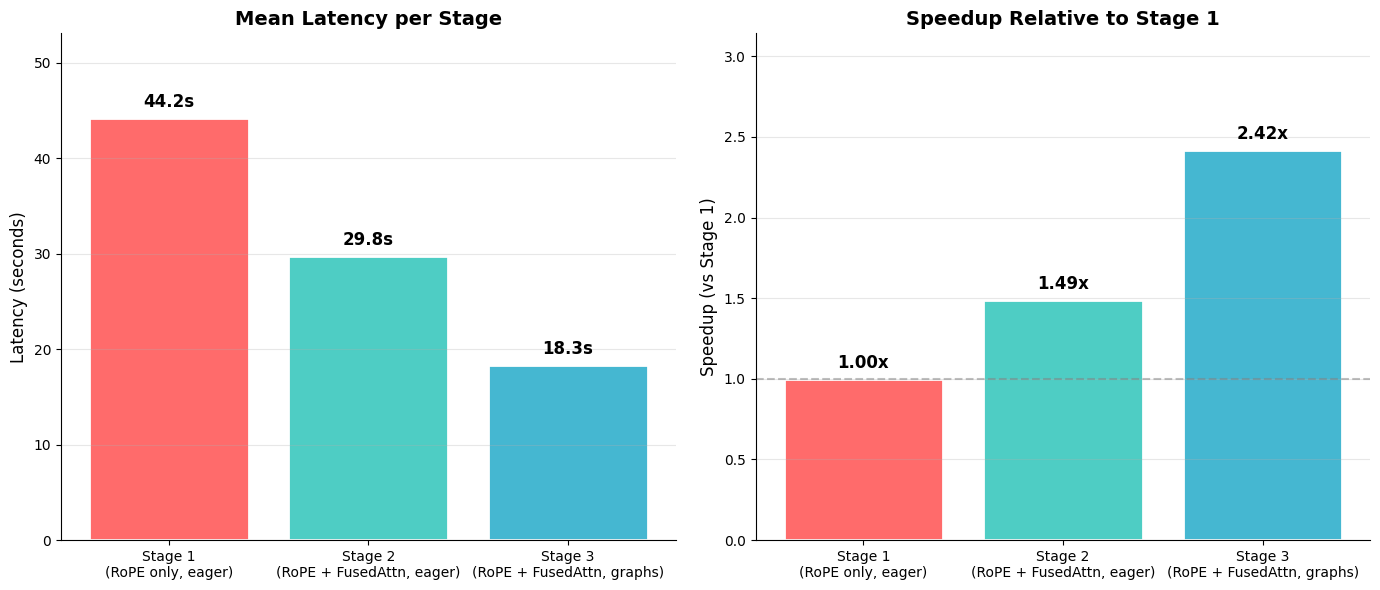


[output] saved_chart=outputs/latency_comparison.png


In [7]:
# Bar Graph Visualization
if latency_results:
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    # Color palette
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
    
    # ===== Plot 1: Mean Latency Comparison =====
    ax1 = axes[0]
    labels = list(latency_results.keys())
    means = [latency_results[l]["mean"] for l in labels]
    
    bars = ax1.bar(labels, means, color=colors[:len(labels)], edgecolor='white', linewidth=2)
    
    # Add value labels on bars
    for bar, mean in zip(bars, means):
        height = bar.get_height()
        ax1.annotate(f'{mean:.1f}s',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 5),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=12, fontweight='bold')
    
    ax1.set_ylabel('Latency (seconds)', fontsize=12)
    ax1.set_title('Mean Latency per Stage', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, max(means) * 1.2)
    ax1.grid(axis='y', alpha=0.3)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # ===== Plot 2: Speedup vs Stage 1 =====
    ax2 = axes[1]
    if len(latency_results) >= 2:
        base_mean = means[0]
        speedups = [base_mean / m for m in means]
        
        bars2 = ax2.bar(labels, speedups, color=colors[:len(labels)], edgecolor='white', linewidth=2)
        
        # Add value labels on bars
        for bar, speedup in zip(bars2, speedups):
            height = bar.get_height()
            ax2.annotate(f'{speedup:.2f}x',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom',
                        fontsize=12, fontweight='bold')
        
        ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5, label='Baseline')
        ax2.set_ylabel('Speedup (vs Stage 1)', fontsize=12)
        ax2.set_title('Speedup Relative to Stage 1', fontsize=14, fontweight='bold')
        ax2.set_ylim(0, max(speedups) * 1.3)
        ax2.grid(axis='y', alpha=0.3)
        ax2.spines['top'].set_visible(False)
        ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('outputs/latency_comparison.png', dpi=150, bbox_inches='tight', facecolor='white')
    plt.show()
    print("\n[output] saved_chart=outputs/latency_comparison.png")
else:
    print("No latency data available. Please run the stages first.")


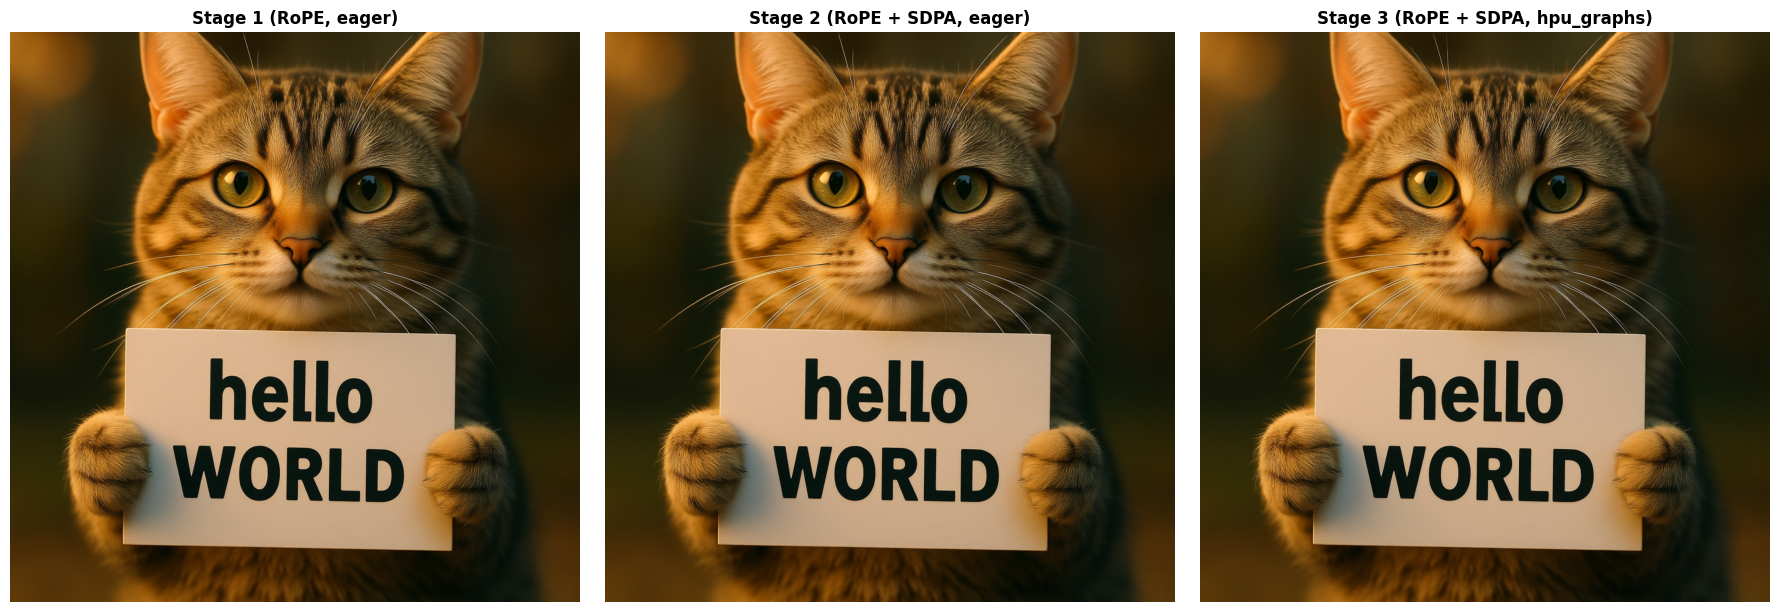

[output] saved_chart=outputs/image_comparison.png


In [8]:
# Display generated images side by side
from PIL import Image
import os

image_files = {
    "Stage 1 (RoPE, eager)": "outputs/stage1_rope_eager.png",
    "Stage 2 (RoPE + SDPA, eager)": "outputs/stage2_rope_sdpa_eager.png",
    "Stage 3 (RoPE + SDPA, hpu_graphs)": "outputs/stage3_rope_sdpa_graph.png",
}

existing_images = {k: v for k, v in image_files.items() if os.path.exists(v)}

if existing_images:
    num_images = len(existing_images)
    fig, axes = plt.subplots(1, num_images, figsize=(6 * num_images, 6))
    
    if num_images == 1:
        axes = [axes]
    
    for ax, (label, img_path) in zip(axes, existing_images.items()):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(label, fontsize=12, fontweight='bold')
        ax.axis('off')
        
        # Add latency info if available
        json_path = img_path.replace('.png', '.json')
        if os.path.exists(json_path):
            with open(json_path, 'r') as f:
                data = json.load(f)
                latency = data['statistics']['mean_sec']
                ax.set_xlabel(f"Mean: {latency:.2f}s", fontsize=11)
    
    plt.tight_layout()
    plt.savefig('outputs/image_comparison.png', dpi=100, bbox_inches='tight', facecolor='white')
    plt.show()
    print("[output] saved_chart=outputs/image_comparison.png")
else:
    print("No images found. Please run the stages first.")
